In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch_lr_finder import LRFinder
import data,utils,models,engine
from torchsummary import summary

C:\Users\pbosamia\Anaconda3\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = {
    'batch_size': 64,
    'shuffle': True,
    'num_workers': 2,
    'pin_memory': True,
}  

In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? False


In [4]:
transform = data.transformed_data()
dataset = data.get_data(transform)
load = data.get_dataloader(dataset, dataloader_args)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

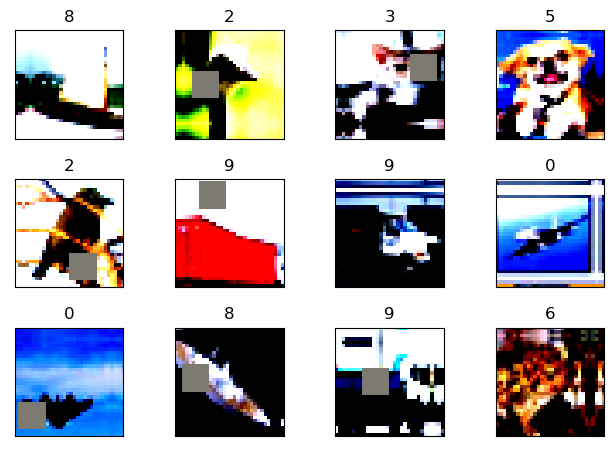

In [6]:
utils.plot_batch_samples(load['train'])

In [9]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
criterion = nn.CrossEntropyLoss()
model = Res_Net().to(device)
summary(model, input_size=(3, 32, 32))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        SkipBlock-14          [-1, 

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.38E-02


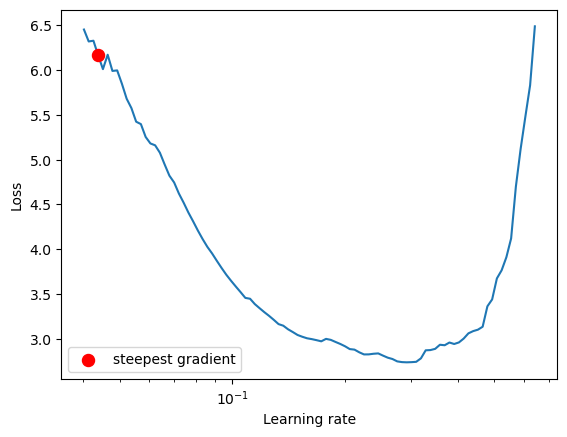

In [13]:
from torch_lr_finder import LRFinder

model = Res_Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1E-3)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cpu")
lr_finder.range_test(load['train'], end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [15]:
import engine

In [ ]:
EPOCHS = {
    'num_epochs': 24,
}
params_scheduler = {
    'max_lr': 4.38E-02, # From lr_finder
    'epochs': EPOCHS ['num_epochs'],
    'steps_per_epoch': len(load['train']), # 1 batch per step
    'pct_start': 0.2, # 20 % warm-up phase
    'anneal_strategy': 'linear', # Linear cool-down phase
    'three_phase': False, # No annihilation phase
    'div_factor': 100, # Initial LR: start from 1 % of max_lr
}

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, **params_scheduler)

results = engine.train(
    device,
    load['train'],
    load['test'],
    model,
    criterion,
    optimizer,
    scheduler,
    EPOCHS['num_epochs'],
)

  0%|          | 0/782 [00:10<?, ?it/s]

Train: Loss = 0.01798, Accuracy = 59.72%, Epoch = 1
Test : Loss = 0.02076, Accuracy = 54.99%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.01975, Accuracy = 55.31%, Epoch = 2
Test : Loss = 0.02200, Accuracy = 50.82%



  0%|          | 0/782 [00:10<?, ?it/s]

Train: Loss = 0.02180, Accuracy = 50.30%, Epoch = 3
Test : Loss = 0.03374, Accuracy = 34.24%



  0%|          | 0/782 [00:10<?, ?it/s]

Train: Loss = 0.02288, Accuracy = 47.46%, Epoch = 4
Test : Loss = 0.02705, Accuracy = 40.88%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.02360, Accuracy = 45.85%, Epoch = 5
Test : Loss = 0.03766, Accuracy = 27.99%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.02342, Accuracy = 46.11%, Epoch = 6
Test : Loss = 0.02703, Accuracy = 38.38%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.02304, Accuracy = 47.23%, Epoch = 7
Test : Loss = 0.03942, Accuracy = 32.07%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.02276, Accuracy = 47.87%, Epoch = 8
Test : Loss = 0.02381, Accuracy = 45.43%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.02226, Accuracy = 48.88%, Epoch = 9
Test : Loss = 0.02253, Accuracy = 48.30%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.02197, Accuracy = 49.97%, Epoch = 10
Test : Loss = 0.02467, Accuracy = 44.91%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.02178, Accuracy = 50.21%, Epoch = 11
Test : Loss = 0.02265, Accuracy = 50.11%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.02143, Accuracy = 51.13%, Epoch = 12
Test : Loss = 0.03052, Accuracy = 37.04%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.02094, Accuracy = 52.31%, Epoch = 13
Test : Loss = 0.02103, Accuracy = 53.40%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.02074, Accuracy = 53.01%, Epoch = 14
Test : Loss = 0.02980, Accuracy = 37.69%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.02026, Accuracy = 53.62%, Epoch = 15
Test : Loss = 0.01982, Accuracy = 54.71%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.01967, Accuracy = 55.49%, Epoch = 16
Test : Loss = 0.01934, Accuracy = 56.88%



  0%|          | 0/782 [00:10<?, ?it/s]

Train: Loss = 0.01945, Accuracy = 56.04%, Epoch = 17
Test : Loss = 0.01881, Accuracy = 58.10%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.01912, Accuracy = 56.90%, Epoch = 18
Test : Loss = 0.01758, Accuracy = 60.59%



  0%|          | 0/782 [00:10<?, ?it/s]

Train: Loss = 0.01858, Accuracy = 58.02%, Epoch = 19
Test : Loss = 0.01838, Accuracy = 58.20%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.01807, Accuracy = 59.24%, Epoch = 20
Test : Loss = 0.01659, Accuracy = 63.02%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.01761, Accuracy = 60.35%, Epoch = 21
Test : Loss = 0.01651, Accuracy = 63.78%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.01696, Accuracy = 61.87%, Epoch = 22
Test : Loss = 0.01507, Accuracy = 65.92%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.01628, Accuracy = 63.36%, Epoch = 23
Test : Loss = 0.01471, Accuracy = 67.00%



  0%|          | 0/782 [00:09<?, ?it/s]

Train: Loss = 0.01555, Accuracy = 65.31%, Epoch = 24


In [ ]:
incorrects = utils.get_incorrect_predictions(
    device,
    data.get_dataloader(dataset, dataloader_args)['test'],
    model,
    criterion
)

In [ ]:
utils.plot_learning_curves(results,EPOCHS ['num_epochs'])

In [ ]:
utils.plot_incorrect_predictions(incorrects, data.CLASSES)